# Data Collection and Modelings

## Example API access to NREL.gov
First I demonstrate how to access the data source NREL. After this, I explain how we use this data to calculate plausible PV outage over days, months, and then years for various locations. Finally, I use this data to train a model to predict the PV outage for the future for various locations.

In [2]:
import sys, os
import pandas as pd
import numpy as np
from IPython.display import display

#idk why this fix does stuff
import ssl
import certifi
import certifi
import urllib
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()
os.environ["SSL_CERT_FILE"] = certifi.where()
context = ssl.create_default_context(cafile=certifi.where())
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())
# ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Declare all variables as strings. Spaces must be replaced with '+', i.e., change 'John Smith' to 'John+Smith'.
# Define the lat, long of the location and the year
lat, lon, year = 33.2164, -118.2437, 2010 #Long is always negative Los Angeles USA: 33.2164, -118.2437
# You must request an NSRDB api key from the link above
api_key = 'i6Pcob8Y47SEHUlKuyjPSu2zozcFv9ne0DuB8aw7'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,air_temperature,relative_humidity,wind_speed'
# Choose year of data
year = year
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '60'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'andrew+xavier'
# Your reason for using the NSRDB.
reason_for_use = 'beta+testing'
# Your affiliation
your_affiliation = 'rice+university'
# Your email address
your_email = 'ahx1@rice.edu'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'true'

# Declare url string
url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
# Return just the first 2 lines to get metadata:
info = pd.read_csv(url, nrows=1)
# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = info['Local Time Zone'], info['Elevation']


In [4]:
# Return all but first 2 lines of csv to get data:
df = pd.read_csv('https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)

# Set the time index in the pandas dataframe:
df = df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

# take a look
print('shape:', df.shape)
df.head()

shape: (8760, 9)


,Year,Month,Day,Hour,Minute,GHI,Temperature,Relative Humidity,Wind Speed
2010-01-01 00:00:00,2010,1,1,0,30,0,15,79.35,2.5
2010-01-01 01:00:00,2010,1,1,1,30,0,15,78.65,3.0
2010-01-01 02:00:00,2010,1,1,2,30,0,15,77.00,3.5
2010-01-01 03:00:00,2010,1,1,3,30,0,15,74.76,3.7
2010-01-01 04:00:00,2010,1,1,4,30,0,15,72.82,3.7


In [7]:
#For LaTeX
print(df.head().to_latex(index=False))  

\begin{tabular}{rrrrrrrrr}
\toprule
 Year &  Month &  Day &  Hour &  Minute &  GHI &  Temperature &  Relative Humidity &  Wind Speed \\
\midrule
 2010 &      1 &    1 &     0 &       0 &    0 &           15 &              79.37 &         2.3 \\
 2010 &      1 &    1 &     0 &      30 &    0 &           15 &              79.35 &         2.5 \\
 2010 &      1 &    1 &     1 &       0 &    0 &           15 &              78.67 &         2.7 \\
 2010 &      1 &    1 &     1 &      30 &    0 &           15 &              78.65 &         3.0 \\
 2010 &      1 &    1 &     2 &       0 &    0 &           15 &              77.03 &         3.3 \\
\bottomrule
\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_22020\3906604345.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.head().to_latex(index=False))


## Data Processing and Calculating PV Output Using NREL Data
The data is too granular to use as it is. As such, I will generate a new column that calculates the power generation using temperature and GHI levels. Then, I will sum them over each day, then average by month giving average total "power" per day per month. We cannot take the average temperature of each day and the average GHI of each day as seen in the EDA section (the GHI levels and temperature levels do not follow the same patterns.)

### Calculations for Energy:
#### The following is based off the equations for PV output given by Homer: 
https://www.homerenergy.com/products/pro/docs/3.11/how_homer_calculates_the_pv_array_power_output.html

Power output in kW for a solar panel is given by:
$$P = Y_{pv}f_{pv}(\frac{G_T}{G_{T,STC}})[1+\alpha*(T_c - T_{c,STC})]$$

$Y_{pv}$ = the rated capacity of the PV array, meaning its power output under standard test conditions [kW]. Best PV array has value of 400W, but some are as low as 260W (https://www.solaris-shop.com/hanwha-q-cells-q-pro-bfr-g4-260-260w-poly-solar-panel/ https://www.solar.com/learn/how-much-energy-does-a-solar-panel-produce/). Note however, this is by cells! 

$f_{pv}$ = the PV derating factor [%]

$G_T$ = the solar radiation incident on the PV array in the current time step [kW/m2]. 

$G_{T,STC}$ = the incident radiation at standard test conditions [1 kW/m2]

α = the temperature coefficient of power [%/°C]

$T_c$ = the PV cell temperature in the current time step [°C]

$T_{c,STC}$ = the PV cell temperature under standard test conditions [25°C]

#### Simplify
$Y_{pv}$ in this example will be 400W based on a 400W panel which are standard in 2022.

We note that $f_{pv}$ does not deviate between locations in ways that are deducable from the given data. Since we largely care about the PV output relative to each location, this is no factored in (thought it would scale the entire dataset from around 0-15%). As such, our equations simplifies to:

$400WG_T[1+\alpha*(T_c - T_{c,STC})]$

Note by doing this, we have change to a scalar multiple of the true Power output!

From: https://wiki.openmod-initiative.org/wiki/Standard_test_conditions#:~:text=STC%20is%20an%20industry%2Dwide,5)%20spectrum. 


We know $T_{c,STC}$ is just 25 degrees Celcius
Our equation becomes:
$$400WG_T[1+\alpha*(T_c - 25\degree C)]$$
$G_T$ is caculated by looking at the radiation incident on the panel which varries by the angle of the sunlight to the panel. However, given that the setup of the solar panel will have either a constant angle or adjust uniformly throughout the day each year and that the sun's path in the sky over each year will follow the same path, we know $G_T$ is proportional to GHI. As such our relative power $P_r$ is calculated by

$$P_r = 400WGHI*[1+\alpha*(T_c - 25\degree C)]$$

Source for $G_T$ from GHI and angles: https://www.homerenergy.com/products/pro/docs/3.11/how_homer_calculates_the_radiation_incident_on_the_pv_array.html

$\alpha$ is given by the manufature of the solar panel and for this example, we will use the value given for Polycrystalline silicon panels: -0.48[%/°C].

Source for $\alpha$ value: https://www.homerenergy.com/products/pro/docs/3.11/pv_temperature_coefficient_of_power.html

The final piece we need is $T_c$. This is the difficult part and will be described below in the Next section

### Getting the temperature of the Cell
From the last section, we know the final piece to our equation to measure the importance of GHI and  ambient temperature is to find the temperature of the cell which is partly a function of the ambient temperature.

$T_c$ is given by: $$T_c = T_a + G_T*\frac{\tau\alpha}{U_L}(1-\frac{\eta}{\tau\alpha})$$
Where:
	
τ = the solar transmittance of any cover over the PV array [%]

α = the solar absorptance of the PV array [%]

$G_T$ = the solar radiation striking the PV array [kW/m2]

η = the electrical conversion efficiency of the PV array [%]

$U_L$ = the coefficient of heat transfer to the surroundings [kW/m2°C]

$T_c$ = the PV cell temperature [°C]

$T_a$ = the ambient temperature [°C]


$\textbf{Deducing our values}$

$\tau*\alpha$ : 0.9, or 90%

HOMER assumes a value of 0.9 for τα in the equation above, as Duffie and Beckman (1991) suggest. Because the term η/τα is small compared to unity, this assumption does not introduce significant error. Source: Duffie JA, Beckman WA (1991), Solar Engineering of Thermal Processes 2nd edition, Wiley, New York, NY

$\eta$: 0.2, or 20%

From umich, we know a reasonable value for this is 15%-20% in commercial panels. We will use 20% for this project
https://css.umich.edu/publications/factsheets/energy/photovoltaic-energy-factsheet#:~:text=PV%20conversion%20efficiency%20is%20the,that%20is%20converted%20to%20electricity.&text=Though%20most%20commercial%20panels%20have,cells%20with%20efficiencies%20approaching%2050%25.

$G_T$:

GHI

$U_L$: $0.01kW/m^2\degree C$

This is tricky as it depends on the temperature of the ambient temperature air velocity, nu, and solar panel temperature. However, Homer provides a neat solution. We can express $\frac{\tau\alpha}{U_L}$ as $$\frac{\tau\alpha}{U_L} = \frac{T_{c,NOCT}- T_{a,NOCT}}{G_{T,NOCT}}$$ (https://www.homerenergy.com/products/pro/docs/latest/how_homer_calculates_the_pv_cell_temperature.html).

$T_{c,NOCT}$ = the nominal operating cell temperature [°C] (45-48 $\degree C$) https://www.homerenergy.com/products/pro/docs/latest/pv_nominal_operating_cell_temperature.html. We will set this to 45°C as this is a feature of the cell and will be constant if the same cell type is used. This does restrict us to use one type of cell in comparison.

$T_{a,NOCT}$ = the ambient temperature at which the NOCT is defined [20°C]

$G_{T,NOCT}$ = the solar radiation at which the NOCT is defined [0.8 kW/m2]

Thus, $$\frac{\tau\alpha}{U_L} = \frac{T_{c,NOCT}- T_{a,NOCT}}{G_{T,NOCT}} = (45-20)/0.8 = \frac{32.25}{kW/m2°C}$$ 
and $$T_c = T_a+(GHI*(45-20)/0.8)*(1-20/90)$$

As a result, our final equation is:
$$ 
P_r = 400W GHI*[1-(0.48\%/\degree C)*[T_a + GHI*(\frac{T_{c,NOCT}- T_{a,NOCT}}{G_{T,NOCT}})*(1-\frac{20}{90}) - 25\degree C]]
$$
Note that $P_r$ is measured in kW. We can also scale the whole equation by the Power rating of the cell ($Y_{PV}$). For example, we can consider our best cell rating of 450W. $\textbf{We will scale our results by this (400W) in our code to get us closer to real world results}$ based on https://www.solar.com/learn/how-much-energy-does-a-solar-panel-produce/.


From here, we can finally fill out our relative power metric column for the efficiency of the solar pannels given GHI and ambient air temperature.



In [27]:
def calcPV_example(ghi, temp):
    #ghi: W/m^2
    #temp: Ambient temperature Celcius 
    #returns cell temp and PV output for a 2
    ghi = ghi/1000 #this is because nrel returns GHI in W/m^2, https://nsrdb.nrel.gov/data-sets/us-data
    t_c = temp+(ghi*(45-20)/0.8)*(1-20/90)
    return t_c, ghi*(1-.0048*(t_c-25))

# We get these from the example locations in LA above
ghi = float(1000.0) #peak outs
temp = float(18.0)
t_c, out= calcPV_example(ghi,temp)
print("Cell temp given ambient is 18 degrees:",t_c)
print("Efficency loss percentage given ambient is 18 degrees",(t_c-25)*0.48,"%")
print("Efficiency of max output:",out, ", 1 kWh for 4.5 hours given ambient is 18 degrees:",out*.400*4.5,"kWh/day")

print("\n")

ghi = float(1000.0) #peak outs
temp = float(0.0)
t_c, out= calcPV_example(ghi,temp)
print("Cell temp given ambient is 18 degrees:",t_c)
print("Efficency loss percentage given ambient is 18 degrees",(t_c-25)*0.48,"%")
print("Efficiency of max output:",out, ", 1 kWh for 4.5 hours given ambient is 18 degrees:",out*.400*4.5,"kWh/day")


Cell temp given ambient is 18 degrees: 42.30555555555556
Efficency loss percentage given ambient is 18 degrees 8.306666666666667 %
Efficiency of max output: 0.9169333333333334 , 1 kWh for 4.5 hours given ambient is 18 degrees: 1.6504800000000004 kWh/day


Cell temp given ambient is 18 degrees: 24.305555555555557
Efficency loss percentage given ambient is 18 degrees -0.33333333333333254 %
Efficiency of max output: 1.0033333333333334 , 1 kWh for 4.5 hours given ambient is 18 degrees: 1.8060000000000003 kWh/day


From our example using temp of 18 degrees in ambient temperature and peak sunlight hours with no cloud cover (~1000W from online sources previously listed), we get 1.6504kWh/day if our unit operates only during peak hours for 4.5 hours. These parameters are used just to make sure we match the example data given often by online resources for solar panel installation in homes. Using https://www.solar.com/learn/how-much-energy-does-a-solar-panel-produce/ as our example, we can see that we are within reasonable values. solar.com gives 1.800kWh/day but assumes maximum efficiency. The model accounts for cell temperature calculations and thus can tell we have a 8.3% efficiency decrease thus giving a lower PV output. If we set our ambient temperature $T_A$ to 0 degrees celcius, we can see cell temperature drops to ~25 degrees, the temperature the manufacture specified to expect 400W output at 1kW of solar radiation, and thus we perfectly match solar.coms results at 1.8kWh/day. I will further justify these results by comparing the estimations over years against SOTA systems.

Lets apply this calculation by taking the GHI and temperature and multiplying it by 1 for each row to get the kWh/hr (in practice we just leave it). We then can sum the values for each day to get kWh/day. For our training data, this is sufficient. For our targets (y values in our regression) we calculate: Average kWh/day for the year, kWh/year, and kWh/month.

## Preprocess data for training:
We can generate 15 data points for each long/lat pair (training is last 5 years, prediction is next year). To get a reasonable dataset, we will do this for 100 different long/lat pairs within a region. This gives us 1500 datapoints. We need to make 2000 API calls thus we will need to automate this step. First, lets process our data for one year using the example data for Los Angeles as given.

In [13]:
#Example for one year using API
from APIs.data_processing import getData, addPV, hoursToDays, daysToMonths, hoursToMonths
# Parameters
api_key = 'KGQPxhHwezmhBj96AirFO6eKuzfP5DvQI7gFDWOk'
your_name = 'andrew+xavier'
your_affiliation = 'columbia+university'
your_email = 'ahx2001@columbia.edu'
lat = 34.0564 #33.2164
lon = -118.2600 # -118.2437
year = 2019
cell_rating = 4 #0.400

#Data processing
df = getData(api_key, your_name, your_affiliation, your_email, lat=lat, lon = lon, year=year) #get raw data from nrel
print("lowest temperature", min(df["Temperature"].values))
df_pv = addPV(df,cell_rating=cell_rating) #Add PV calculated column
df_pv_day = hoursToDays(df_pv) # Convert to day level granularity
df_pv_month = daysToMonths(df_pv_day)
print("Daily for Los Angeles \n",df_pv_day.head()) #display results
print("Monthly for Los Angeles\n", hoursToMonths(df_pv).head())#faster version check
print(np.sum(df_pv_month["PV kWh/month"]))


lowest temperature 2.1
Daily for Los Angeles 
    Year  Month  Day  Temp mean    GHI mean  PV kWh/day
0  2019      1    1   7.529167  151.333333   14.633152
1  2019      1    2   9.750000  147.208333   14.056564
2  2019      1    3  10.775000  151.375000   14.338817
3  2019      1    4  11.912500  148.000000   13.967583
4  2019      1    5  11.758333   41.458333    4.136171
Monthly for Los Angeles
    Year  Month  Temp mean    GHI mean  PV kWh/month
0  2019      1  13.057527  115.553763    339.329723
1  2019      2  10.366071  141.532738    379.628972
2  2019      3  13.820833  208.123656    595.106440
3  2019      4  16.594028  254.502778    688.621421
4  2019      5  16.125403  248.805108    696.927243
7023.02081932


## Validate our results against SOTA
We can use NREL's online calculator that leverage their SOTA SAM model to validate our approximation results. I use Los Angeles as my location and match the inputs for a 4kW cell system with no tilt and no system loss due to internal cell components (derating factor) as previously explained. 

In [14]:
#Validate against SOTA SAM model: https://pvwatts.nrel.gov/pvwatts.php
from APIs.data_processing import getData, addPV, hoursToDays, daysToMonths, dataByLocation

# Parameters
api_key = 'KGQPxhHwezmhBj96AirFO6eKuzfP5DvQI7gFDWOk'
your_name = 'andrew+xavier'
your_affiliation = 'columbia+university'
your_email = 'ahx2001@columbia.edu'
lat = 34.0564 #33.2164
lon = -118.2600 # -118.2437
end_year = 2020
cell_rating = 4 #0.400

import pandas as pd
data = dataByLocation(api_key, your_name, your_affiliation, your_email, lat, lon, cell_rating,end_year) #Get all years of data
file_name = "API_data/lon_lat{location}.csv".format(location = lon+lat)
data.to_csv(file_name, index = False)

In [26]:
df = pd.read_csv(file_name)
df.columns
print("Expected SOTA from SAM: 6,968. With a range from 6,639 to 7,114 kWh per year")
print("Our mean value:",format(np.sum(df["PV kWh/month"])/23,".2f"), "kWh/Year")
print("error % = ", (abs(np.sum(df["PV kWh/month"])/23 - 6968)/6968)*100)

Expected SOTA from SAM: 6,968. With a range from 6,639 to 7,114 kWh per year
Our mean value: 7023.43 kWh/Year
error % =  0.7954700393933352


Our results are very close to the predictions for NREL's SAM model and well within its range of expected values!

Now we have made sure all our API functions are working and online! Time to get data for many locations. These locations are the ones described in "1 Map Visualization and Data Selection.ipynb". The data points are saved in API_data.

**During the data gathering process, due to the large number of requests, it is possible for the script to fail due to request limits by NREL. To account for this, it is recommended to save data in sections as I have done and then concatinate the results.**

In [4]:
#Generate training data across all points:
""" 
Runtime is ~1min 30sec/point. Over 100 points takes around 150 minutes
Adjust the overal

Change the following two parameters as needed and the start and stop points in points below:
"""

file_name = "API_data/x_train_all.csv" #Change number to end point index
lastpoint = 142 #set same as start time

import pandas as pd
from APIs.data_processing import getData, addPV, hoursToDays, daysToMonths, dataByLocation
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Parameters
api_key = 'i6Pcob8Y47SEHUlKuyjPSu2zozcFv9ne0DuB8aw7'
your_name = 'andrew+xavier'
your_affiliation = 'columbia+university'
your_email = 'ahx1@rice.edu'
cell_rating = 0.400
end_year = 2021 #data is 1998-end_year, max is 2021


#generate lon lat points:
lon = -104.0000 #for all values
points = []
#lat starts at 20.0000 and incriments by .045 each step
for lat in range(20000, 27000, 45):
    points.append([format(lat/1000,'.4f'), format(lon,'.4f')])
# print(points[1], "exected 20.0450, -104.0000")


#Generate all our points! This will run for an hour or so
x_train = pd.DataFrame(columns=["Year", "Month", "Temp mean", "GHI mean", "PV kWh/month"])
for point in points[0:len(points)]: #Update this before running!!!!!!!!!!!!!!!!!!!! <----------------------- Leave as is for all points
    lat = point[0]
    lon = point[1]
    data = dataByLocation(api_key, your_name, your_affiliation, your_email, lat, lon, cell_rating, end_year=end_year)
    x_train = pd.concat([x_train, data])
    x_train.to_csv(file_name, index = False)
    lastpoint += 1
    print(lastpoint)
print("num training points", len(x_train))


143
144
145
146
147
148
149
150
151
152
153
154
155
156
num training points 3864


In [3]:
#Concat data for final set
import pandas as pd
df = pd.read_csv("API_data/x_train_10.csv")
df = pd.concat([df, pd.read_csv("API_data/x_train_50.csv")])
df = pd.concat([df, pd.read_csv("API_data/x_train_59.csv")])
df = pd.concat([df, pd.read_csv("API_data/x_train_120.csv")])
df = pd.concat([df, pd.read_csv("API_data/x_train_142.csv")])
df = pd.concat([df, pd.read_csv("API_data/x_train_156.csv")])
df.to_csv("API_data/x_train.csv",index=False)

## Modeling
I use a simple linear regression model to create my predictions with my features being previous values and my targets being the relative PV out values for months for various numbers of years into the future. This is best for filling in missing data points

In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

########################################################################################################################
#PARAMETERS:
years_ahead = 3 # How far in the future we should predict in years (1-22). Ex 1 means predict 1 values for 1 year in the future.
num_years = 5 #Number of years used to predict future values. Ranges from 1 to 23 minus the years_ahead 

##Combinations to try: 
# Use 7 years to predict, predict 2 years ahead (decent)
# Use 10 years to predict, predict 4 years ahead
# Use 1 years to predict, predict 1 years ahead (Underfitting)
# Use 15 years to predict, predict 1 year ahead (Overfitting)

########################################################################################################################


x_set = [] #our inputs to train
y_set = [] #our inputs to train

df = pd.read_csv("API_data/x_train.csv") #read in our data
########
#TO DO:
#Create train-test split to validate on later. Right now just training
########


#generate lon lat points NEED TO UPDATE THIS FOR TRAIN TEST SPLIT!:
lon = -104.0000 #for all values
points = []
#lat starts at 20.0000 and incriments by .045 each step
for lat in range(20000, 27000, 45):
    points.append([format(lat/1000,'.4f'), format(lon,'.4f')])

for location in points: #iterate over each point to build point prediction pairs
    df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1]))] #select location
    X = df_loc.values
    X = preprocessing.normalize(X) #normalize test set
    y = df_loc["PV kWh/month"].tolist()
    for i in range(len(X)//12 - num_years-years_ahead+1):
        x_set.append(X[i*12:i*12+12*num_years].flatten())
        y_set.append(y[i*12+12*num_years+12*(years_ahead-1):i*12+12*num_years+12+12*(years_ahead-1)])

#train test split:
x_train, x_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.20,shuffle=True,random_state = 20)

#convert to array
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print("shape of x_train",x_train.shape)
print("shape of y_train", y_train.shape)
# print("num of points to predict used correct?", x_train.shape[1]/(12*7) == num_years)
print("\n")
#train model

reg = RandomForestRegressor(random_state=0).fit(x_train,y_train) #can switch out with a LinearRegression() 
print("score on training (R2), closer to 1 is better:", format(reg.score(x_train,y_train),'.4f'))
print("score on testing (R2), closer to 1 is better:", format(reg.score(x_test,y_test),'.4f'))

#Testing
x_test = preprocessing.normalize(df.values)[-num_years*12:].flatten()
print("Predictions for power output PV (kWh/month) for each month in", years_ahead ,"year(s) after", int((df.values)[-num_years*12:].flatten()[-7]),"in location lat long =", (df.values)[-num_years*12:].flatten()[-2:]) 
prediction = reg.predict([x_test])[0]
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
tab = [] #just for LaTeX output 
for index, month in enumerate(months):
    print(month,prediction[index],"kWh/Month")
    tab.append([month,prediction[index],"kWh/Month"])



shape of x_train (1996, 420)
shape of y_train (1996, 12)


score on training (R2), closer to 1 is better: 0.9934
score on testing (R2), closer to 1 is better: 0.9572
Predictions for power output PV (kWh/month) for each month in 3 year(s) after 2020 in location lat long = [  26.975 -104.   ]
Jan 52.84803375012001 kWh/Month
Feb 53.695330304146665 kWh/Month
March 72.36685895597336 kWh/Month
April 80.03798227157331 kWh/Month
May 87.4313168206667 kWh/Month
June 80.34497632754666 kWh/Month
July 79.63917093176 kWh/Month
Aug 78.78815128318668 kWh/Month
Sept 63.685693962453364 kWh/Month
Oct 61.87905598909334 kWh/Month
Nov 51.719745228560015 kWh/Month
Dec 50.71919702717335 kWh/Month


## Not including temporal mix
In order to use our model to predict for points in the future, we must isolate its training data temporaly.

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd

########################################################################################################################
#PARAMETERS:
years_ahead = 1 # MUST be 1 in this case
num_years = 10 #Number of years used to predict future values. Ranges from 1 to 23 minus the years_ahead 

##Combinations to try: 
# Use 7 years to predict, predict 2 years ahead (decent)
# Use 10 years to predict, predict 4 years ahead
# Use 1 years to predict, predict 1 years ahead (Underfitting)
# Use 15 years to predict, predict 1 year ahead (Overfitting)

########################################################################################################################


x_set = [] #our inputs to train
y_set = [] #our inputs to train

df = pd.read_csv("API_data/x_train.csv") #read in our data


#generate lon lat points NEED TO UPDATE THIS FOR TRAIN TEST SPLIT!:
lon = -104.0000 #for all values
points = []
#lat starts at 20.0000 and incriments by .045 each step
for lat in range(20000, 27000, 45):
    points.append([format(lat/1000,'.4f'), format(lon,'.4f')])
x_test = [] #to generate test set
y_test = []
for location in points: #iterate over each point to build point prediction pairs
    df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1])) & (df["Year"] != 2020)] #select location
    X = df_loc.values
    X = preprocessing.normalize(X)
    #  #normalize test set
    y = df_loc["PV kWh/month"].tolist()
    x_test.append(X[-12*num_years:].flatten()) #want the last num_years for each location for testing
    for i in range(len(X)//12 - num_years-years_ahead+1):
        x_set.append(X[i*12:i*12+12*num_years].flatten())
        y_set.append(y[i*12+12*num_years+12*(years_ahead-1):i*12+12*num_years+12+12*(years_ahead-1)])

    df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1])) & (df["Year"] == 2020)] #select location
    y = df_loc["PV kWh/month"].tolist()# want the next year
    y_test.append(y)


#convert to array
x_train = np.asarray(x_set)
y_train = np.asarray(y_set)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print("shape of x_train",x_train.shape)
print("shape of y_train", y_train.shape)
# print("num of points to predict used correct?", x_train.shape[1]/(12*7) == num_years)
print("\n")

#train model
reg = RandomForestRegressor(max_depth=2).fit(x_train,y_train) #can switch out with a LinearRegression() 
print("score on training (R2), closer to 1 is better:", format(reg.score(x_train,y_train),'.4f'))
print("score on testing (R2), closer to 1 is better:", format(reg.score(x_test,y_test),'.4f'))

#Testing
x_test = preprocessing.normalize(df.values)[-num_years*12:].flatten()
y_test = y_test[-1]
print("Predictions for power output PV (kWh/month) for each month in", years_ahead ,"year(s) after", int((df.values)[-num_years*12:].flatten()[-7]),"in location lat long =", (df.values)[-num_years*12:].flatten()[-2:]) 
prediction = reg.predict([x_test])[0]
months = ["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
tab = [] #just for LaTeX output 
for index, month in enumerate(months):
    print("Predicted",month,prediction[index],"kWh/Month", "True",month,y_test[index],"kWh/Month")
    tab.append([month,prediction[index],"kWh/Month"])





shape of x_train (1872, 840)
shape of y_train (1872, 12)


score on training (R2), closer to 1 is better: 0.3286
score on testing (R2), closer to 1 is better: -3.0607
Predictions for power output PV (kWh/month) for each month in 1 year(s) after 2020 in location lat long = [  26.975 -104.   ]
predicted Jan 50.35866639970251 kWh/Month True Jan 48.677702292000006 kWh/Month
predicted Feb 53.03325808964786 kWh/Month True Feb 54.250876825333336 kWh/Month
predicted March 71.78966229769627 kWh/Month True March 65.38398722266666 kWh/Month
predicted April 78.59060085134101 kWh/Month True April 76.48001033733334 kWh/Month
predicted May 85.90976398887449 kWh/Month True May 87.66101766266667 kWh/Month
predicted June 77.59701977443622 kWh/Month True June 80.39550647066667 kWh/Month
predicted July 82.19858242987034 kWh/Month True July 79.77037213866667 kWh/Month
predicted Aug 80.00729611835781 kWh/Month True Aug 82.68266143600002 kWh/Month
predicted Sept 66.62728994120593 kWh/Month True Sept 63.10631

# Conclusion
We can see our test score is negative when we isolate our data temporally! What this means is that our predictions were, on average, worse than if we just guessed the mean of the previous data points. However, we can see our predictions are not dramatically off from the actual values. What is likely the case, is there there is not statistically correlation between time (in the last 20 years) and the PV output potential for various locations. While dissapointing for the model's predictive power, in a way this is not a bad result as had the model picked up a generalized trend, it would likely correspond to dramatic changes in our climate as the features that determine PV are those deriving from climate. However, given more years of data, it is likely the model would see the 0.18 C increase in global temperature per year since 1880 which is more subtle. 

### Note that this still allows us to complete our objective of choosing good locations to build solar panels at
The results for this area just happens to be best determined by choosing the location with the currently best PV output history and our model helps validate that approach. In fact, if we look at our example from comparing to SOTA, if we use the mean of our calculations, our error is only 0.79%. 

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd
df = pd.read_csv("API_data/x_train.csv") #read in our data

best_point = [] #
best_PV = 0 #
#generate lon lat points NEED TO UPDATE THIS FOR TRAIN TEST SPLIT!:
lon = -104.0000 #for all values
points = []
#lat starts at 20.0000 and incriments by .045 each step
for lat in range(20000, 27000, 45):
    points.append([format(lat/1000,'.4f'), format(lon,'.4f')])

for location in points: #iterate over each point to build point prediction pairs
    df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1])) ]
    monthly_data = df_loc["PV kWh/month"].values.tolist()
    prediction = np.sum(monthly_data)/23
    if prediction > best_PV:
        print(location,prediction)
        best_PV = prediction
        best_point = location

print("Best Location", best_point)
print("Expected Annual PV output in kWh/Year:", best_PV)


['20.0000', '-104.0000'] 779.8614038832465
['20.0450', '-104.0000'] 795.7640997696811
['20.0900', '-104.0000'] 797.3016455908986
['20.2700', '-104.0000'] 806.1674369813915
['20.3150', '-104.0000'] 822.0396409086377
['20.4050', '-104.0000'] 833.5049596979131
['20.7200', '-104.0000'] 835.3512119773333
['20.9900', '-104.0000'] 841.1996682281161
['21.3500', '-104.0000'] 841.2258722550724
['21.3950', '-104.0000'] 847.8422960369855
['21.4400', '-104.0000'] 858.2725860794784
Best Location ['21.4400', '-104.0000']
Expected Annual PV output in kWh/Year: 858.2725860794784


## LaTeX and trend observations

In [170]:
#LATEX ouputs
import scipy
from tabulate import tabulate
print(tabulate(tab, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{lrl}
\hline
 Jan   & 53.11 & kWh/Month \\
 Feb   & 52.86 & kWh/Month \\
 March & 72.34 & kWh/Month \\
 April & 79.46 & kWh/Month \\
 May   & 86.75 & kWh/Month \\
 June  & 80.23 & kWh/Month \\
 July  & 79.96 & kWh/Month \\
 Aug   & 79.37 & kWh/Month \\
 Sept  & 64.09 & kWh/Month \\
 Oct   & 60.28 & kWh/Month \\
 Nov   & 52.39 & kWh/Month \\
 Dec   & 50.66 & kWh/Month \\
\hline
\end{tabular}


Text(0.5, 1.0, "PV output for January over years since 1998 for lat/long =['20.0000', '-104.0000']")

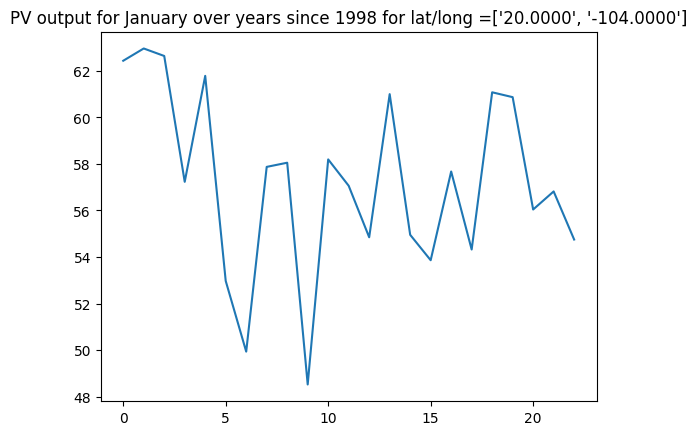

In [189]:
import matplotlib.pyplot as plt
location = points[0]
df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1])) &(df["Month"]==1)]
y = df_loc["PV kWh/month"].tolist()
plt.plot(y)
plt.title('PV output for January over years since 1998 for lat/long ={loc}'.format(loc=location))


#### Experimentation with simple autoregressive models

In [40]:

import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
location = points[0]
avg_score = []
for location in points:
    df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1])) & (df["Year"] != 2020)]
    X = df_loc[["Month","Temp mean"]].values.tolist()
    y = df_loc["PV kWh/month"].tolist()
    clf = linear_model.ARDRegression()
    clf.fit(X, y)
    # print(clf.score(X,y))
    df_loc = df.loc[(df['lat'] == float(location[0])) & (df['lon'] == float(location[1])) & (df["Year"] == 2020)]
    X = df_loc[["Month","Temp mean"]].values.tolist()
    y = df_loc["PV kWh/month"].tolist()
    avg_score.append(clf.score(X,y))
    # print(clf.predict(X)[0],y[0])
    if abs(clf.predict(X)[0]- y[0]) < 2:
        print("match")
print(np.mean(avg_score))



0.5751978666174752
